# Refactor of cryst_heat_load_pub 

Use numba to speed up some calculations.

In [1]:
from cryst_heat_load_pub import R_for_deform, depth_flow_heat

In [2]:
import numpy as np
from numba import njit
from matplotlib import pyplot as plt
from math import *
import matplotlib
import glob
import pylab
#matplotlib.use('Agg')
%config InlineBackend.figure_format = 'retina'

In [4]:
material = "si"
rho_choice = {"si": 2.33} #define the material density in g/cm^3
pulse_energy = 1e-3 #define pulse energy in J
FWHM_norm = 550 #define the pulse FWHM that is incident at Bragg angle
en_ev0 = 9000 #define central photon energy in eV
pul_in_tr = 50 #define number of pulses in a train
abs_len = 97 #abs. length, um
T_init = 100 #initial temp., K
reprate = 2.25 #repetition rate, MHz
XGM_trend = pulse_energy*1e6*np.ones(pul_in_tr) #defines a train of pulses with energy pulse_energy in uJ

rho = rho_choice[material]
T_min = 1
T_max = 15e3
T_points = int(15e4)
th_B= np.arcsin(12.4/en_ev0/1e-3/2/3.1355)

#import specific heat
cp_T = np.loadtxt(glob.glob("*cp*"+material+"*.dat")[0])[:,0]
cp_raw = np.loadtxt(glob.glob("*cp*"+material+"*.dat")[0])[:,1]

#import thermal conductivity
lambda_T = np.loadtxt(glob.glob("*lambda*"+material+"*.dat")[0])[:,0]
lambda_raw = np.loadtxt(glob.glob("*lambda*"+material+"*_28.dat")[0])[:,1]

#import linear thermal expansion coefficient
alpha_exp_T = np.loadtxt(glob.glob("*alpha*"+material+"*.dat")[0])[:,0]
alpha_exp_raw = np.loadtxt(glob.glob("*alpha*"+material+"*.dat")[0])[:,1]*1e-6

T_arr = np.linspace(T_min,T_max,T_points)

cp_arr = np.interp(T_arr,cp_T,cp_raw)
heat_int = np.cumsum(cp_arr)*(T_arr[1]-T_arr[0]) #J/g to heat to each temperature from 1K

lambda_arr = np.interp(T_arr,lambda_T,lambda_raw)
alpha_exp_arr = np.interp(T_arr,alpha_exp_T,alpha_exp_raw)


x_rad = 2000 #crystal radius, um

#this variable depends on the pulse energy and repetition rate and needs to be adjusted such that
#temperature distributions below do not change for with an increasing thickness
thick = 600 #crystal thickness, um
step_z = 2 #step in depth direction

z_dots = int(thick/step_z)
dz = thick/z_dots
z_arr = np.linspace(0,thick,z_dots)

x_dots = int(150)
dx = x_rad/x_dots
dy = x_rad/x_dots
x_arr = np.linspace(0,x_rad,x_dots)

x_area = np.zeros(x_dots)
x_area[0]=np.pi*dx*dx
x_area[1:]=np.pi*((x_arr[1:]+dx)**2-x_arr[1:]**2)
x_vol = np.copy(x_area)*dz
x_mass = np.copy(x_vol)*rho*1e-12


FWHM_beam = FWHM_norm*np.sqrt(1/sin(th_B)) #beamsize, um

sigma_gaus = FWHM_beam/(2*np.sqrt(2*np.log(2)))

heat_0 = heat_int[np.argmin(np.abs(T_arr[:]-T_init))]


pul_sep = 1/reprate #pulse separation, us
iter_num = 5000  #iterations for each pulse
iter_dur = pul_sep #time for which to calculate evolution, us
dt = iter_dur/iter_num

gaus_beam_rel = np.zeros((x_dots,z_dots))
xz_heat_rel = np.zeros((x_dots,z_dots))
abs_Br_inc = abs_len*sin(th_B)

for ix in np.arange(x_dots):
    for iz in np.arange(z_dots):
        gaus_beam_rel[ix,iz] = x_area[ix]*        np.exp(-(x_arr[ix]+dx/2)*(x_arr[ix]+dx/2)/2/sigma_gaus/sigma_gaus)/        2/np.pi/sigma_gaus/sigma_gaus*        np.exp(-z_arr[iz]/abs_Br_inc)*dz/abs_Br_inc#incident energy at each x and z, J

        xz_heat_rel[ix,iz] = gaus_beam_rel[ix,iz]/x_mass[ix] #1/g heat absorbed at each x and z


heat_pulse_ip = xz_heat_rel*pulse_energy
T_pulse = np.interp(heat_pulse_ip,heat_int-heat_0,T_arr)
ip_arr = np.arange(0,pul_in_tr,1)



args=[(T_pulse[x_i,:],
       lambda_arr,cp_arr,iter_num,dt,T_arr,T_init,dz,
       x_area[x_i],rho,x_vol[x_i],    1,XGM_trend,xz_heat_rel[x_i],x_i, 
       ip_arr, heat_int, heat_0)        for x_i in np.arange(x_dots)]

# Numba timing

In [5]:
%%time
res1 = depth_flow_heat(*args[0])

CPU times: user 13.1 s, sys: 39.1 ms, total: 13.1 s
Wall time: 13.2 s


In [6]:
# numba jitted version
jitted_depth_flow_heat = njit(depth_flow_heat)

In [8]:
%%time
res2 = jitted_depth_flow_heat(*args[0])

CPU times: user 3.31 s, sys: 26.9 ms, total: 3.34 s
Wall time: 3.32 s


In [ ]:
#with multiprocessing.Pool(max_processors) as p:
#    results = p.map(depth_flow_heat, args)

# Parallel calculation

In [9]:
# Allows processes to work with macOS
from sys import platform 
if platform == 'darwin':
    import multiprocessing as mp
    mp.set_start_method("fork")
from concurrent.futures import ProcessPoolExecutor

In [10]:
%%time
with ProcessPoolExecutor() as executor:
    def f(a):
        return jitted_depth_flow_heat(*a)
    results = list(executor.map(f, args) )

CPU times: user 563 ms, sys: 970 ms, total: 1.53 s
Wall time: 2min 24s


In [12]:
T_pulse_surf = np.stack(np.asarray(results)[:,1])
T_pulse=np.stack(np.asarray(results)[:,0])

/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/ipykernel_41645/3604041101.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T_pulse_surf = np.stack(np.asarray(results)[:,1])
/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/ipykernel_41645/3604041101.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T_pulse=np.stack(np.asarray(results)[:,0])


# Plot temperature distribution at surface at the moment of arrival of #Nth pulse

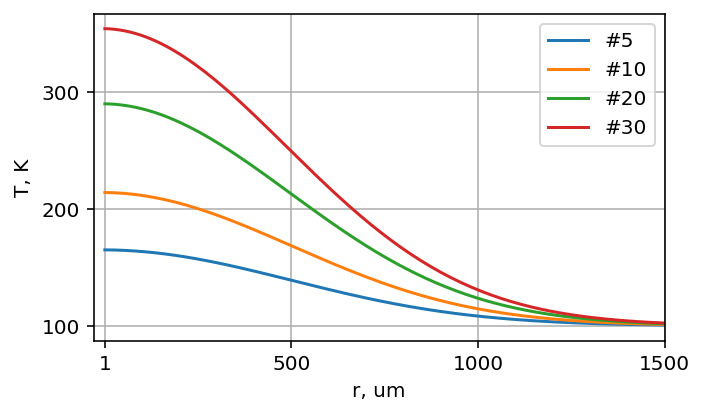

In [21]:
fig,ax = plt.subplots(figsize=(5,3))
for ip_plot in [4,9,19,29]:
#     line, = ax.plot(x_arr,T_pulse_surf[:,ip_plot],\
#          label="pulse #{:.0f}, {:.0f} mJ".format(ip_plot,np.cumsum(XGM_trend)[ip_plot-1]*1e-3))
    line, = ax.plot(x_arr,T_pulse_surf[:,ip_plot],         label="#{:.0f}".format(ip_plot+1))

# for ip_plot in [1,15,50,100,175]:
#     line, = ax.plot(x_arr,T_pulse_surf[:,ip_plot],\
#          label="{:.1f} mJ".format(0.28*np.cumsum(XGM_trend)[ip_plot-1]*1e-3))
# ax.plot(z_arr,T_pulse[0,:],'--',\
#        color=line.get_color())

# plt.title('Temperature profile at surface')    
plt.xlim(-30,1500)
plt.xticks(ticks=(1,500,1000,1500))
plt.yticks(ticks=(100,200,300))
plt.legend()
plt.grid()
plt.xlabel('r, um')
plt.ylabel('T, K')
plt.tight_layout()
fig.savefig('T_profile.png', dpi=150)

In [14]:
deform_int = np.cumsum(alpha_exp_arr)*(T_arr[1]-T_arr[0])
deform_init = np.interp(T_init,T_arr,deform_int)

x_heat_rel = x_area*np.exp(-(x_arr+dx/2)*(x_arr+dx/2)/2/sigma_gaus/sigma_gaus)/        2/np.pi/sigma_gaus/sigma_gaus

RC_d_ens = np.linspace(-3,3,300)

T_pulse_surf[:,0] = T_init
RC_Rs_ips_sigma = np.zeros((pul_in_tr+1,len(RC_d_ens)))
for ip in ip_arr:
    deform_x = np.interp(T_pulse_surf[:,ip],T_arr,deform_int)-deform_init
    for d_en_i in np.arange(len(RC_d_ens)):
        d_en = RC_d_ens[d_en_i]
        R_x = R_for_deform(d_en, deform_x, en_ev0,x_heat_rel, 'sigma')
        RC_Rs_ips_sigma[ip,d_en_i] = np.sum(R_x)



# Rocking curve of #Nth pulse in a train

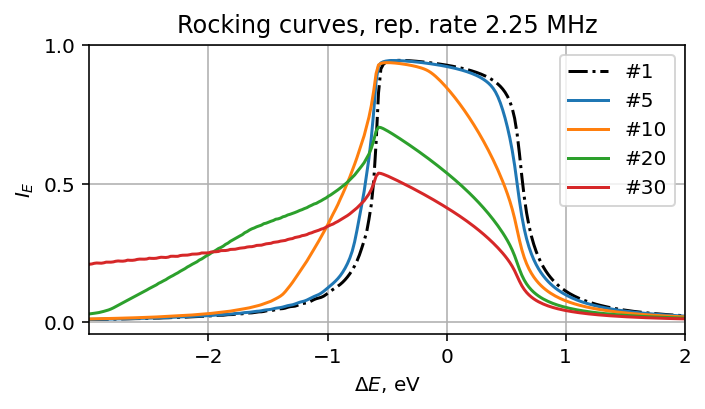

In [20]:
plt.figure(figsize=(5,3))
# print(np.shape(RC_Rs_ips_sigma))
plt.title('Rocking curves, rep. rate {:.2f} MHz'.format(reprate))
shift_RC_dots = 1
RC_Rs_sigma_cold = np.copy(RC_Rs_ips_sigma[0])
RC_Rs_sigma_cold[shift_RC_dots:] = RC_Rs_ips_sigma[1][:-shift_RC_dots]
plt.plot(RC_d_ens,RC_Rs_sigma_cold,'k-.',label='#1')

for ip in [4,9,19,29]:
# for ip in [1,50,100,150,174]:
    plt.plot(RC_d_ens,RC_Rs_ips_sigma[ip,:],label="#{:.0f}".format(ip+1,np.cumsum(XGM_trend)[ip-1]*1e-3))
plt.legend()
plt.grid()
plt.xlabel('$\Delta E$, eV')
plt.ylabel('$I_E$')
plt.tight_layout()
plt.xticks(ticks=(-2,-1,0,1,2))
plt.xlim(-3,2)
plt.yticks(ticks=(0,0.5,1))
fig.savefig('RCs.png', dpi=150)

# Transmission of two-crystal monochromator where 1st crystal is heated as above and 2nd crystal stays cold



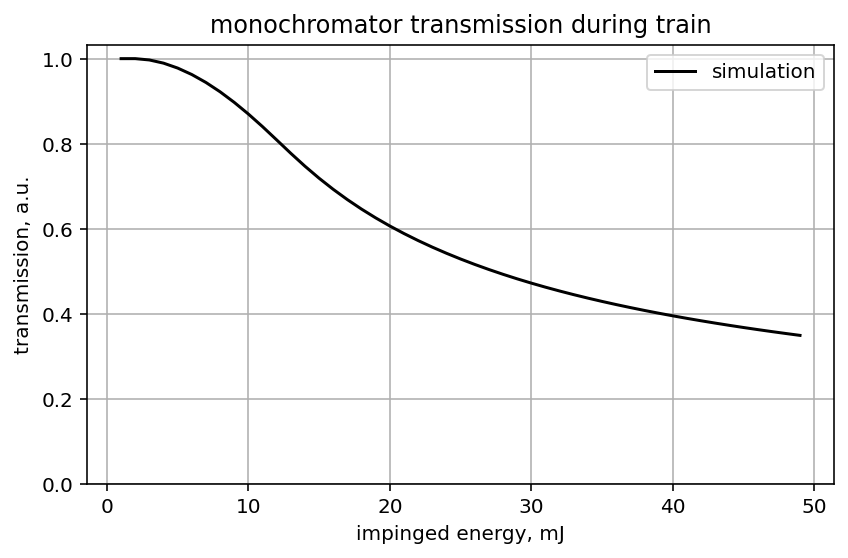

In [19]:
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title('monochromator transmission during train')
XGM_cumsum = np.cumsum(XGM_trend)*1e-3
plot_RC0 = np.sum(RC_Rs_sigma_cold*RC_Rs_ips_sigma[1])
bunches = 250
plot_RC = np.zeros(pul_in_tr)
for ip in ip_arr[:bunches]:
    plot_RC[ip] = np.sum(RC_Rs_sigma_cold*RC_Rs_ips_sigma[ip])

    
# for ip in ip_arr[:bunches]:
#     ax2.plot(np.arange(len(plot_RC)),plot_RC,'ro',label='simulation')
ax1.plot(XGM_cumsum[:-1],plot_RC[1:]/plot_RC[1],'k-',label='simulation')
#     plt.plot(ip,deriv_RC_int[ip]/np.amin(deriv_RC_int[start_drop:]),'bo')
# ax2.set_ylim(0)
# ax2.tick_params(axis='y', colors='r')
ax1.legend()
ax1.set_ylabel('transmission, a.u.')
ax1.grid()
ax1.set_xlabel('impinged energy, mJ')
ax1.set_ylim(0)
plt.tight_layout()
fig.savefig('transm_train.png', dpi=150)